In [1]:
import numpy as np
params = {'setup': 'setup/tmaze.npy',
          'prev_edited': 'port-mappings/default.csv'}
np.save('../params.npy', params)
tmaze= {'map-file': 'port-mappings/default.csv',
        'vis-name': 'TMAZEVis'}
np.save('../setups/TMAZE/params.npy', tmaze)


triggering reward on arm s


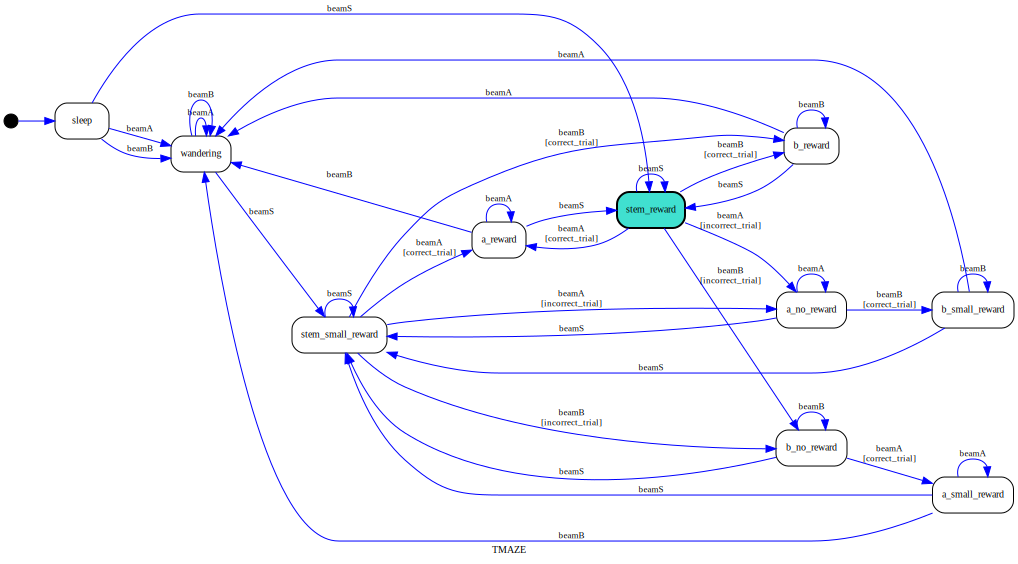

In [6]:
from statemachine import StateMachine, State
import pandas as pd
class TMAZE(StateMachine):

    sleep = State("sleep", initial=True)
    stem_reward= State("stem_reward")
    stem_small_reward = State("stem_small_reward")

    a_reward= State("a_reward")
    a_no_reward = State("a_no_reward")
    a_small_reward = State("a_small_reward")

    b_reward= State("b_reward")
    b_no_reward = State("b_no_reward")
    b_small_reward = State("b_small_reward")

    wandering = State("wandering")

    beamA =  ( stem_reward.to(a_reward, cond="correct_trial",  on = "deliver_reward") 
               | stem_reward.to(a_no_reward, cond="incorrect_trial") 
               | stem_small_reward.to(a_reward, cond="correct_trial",  on = "deliver_reward") 
               | stem_small_reward.to(a_no_reward, cond="incorrect_trial") 
               | b_no_reward.to(a_small_reward, cond = "correct_trial",  on = "deliver_small_reward")
               | b_reward.to(wandering) |  b_small_reward.to(wandering)
               | sleep.to(wandering) | wandering.to.itself()
               | a_reward.to.itself() 
               | a_no_reward.to.itself() 
               | a_small_reward.to.itself()
    )


    beamB =  ( stem_reward.to(b_reward, cond="correct_trial", on = "deliver_reward") 
               | stem_reward.to(b_no_reward, cond="incorrect_trial") 
               | stem_small_reward.to(b_reward, cond="correct_trial",  on = "deliver_reward") 
               | stem_small_reward.to(b_no_reward, cond="incorrect_trial") 
               | a_no_reward.to(b_small_reward, cond = "correct_trial",  on = "deliver_small_reward")
               | a_reward.to(wandering) | a_small_reward.to(wandering)
               | sleep.to(wandering) | wandering.to.itself() 
               | b_reward.to.itself() 
               | b_no_reward.to.itself() 
               | b_small_reward.to.itself()
    )

    beamS =  ( a_reward.to(stem_reward,  on =  "toggle_target") 
               | a_no_reward.to(stem_small_reward,  on =  "toggle_target") 
               | a_small_reward.to(stem_small_reward,  on = "toggle_target")
               | b_reward.to(stem_reward,  on =  "toggle_target") 
               | b_no_reward.to(stem_small_reward,  on =  "toggle_target") 
               | b_small_reward.to(stem_small_reward,  on =  "toggle_target") 
               | wandering.to(stem_small_reward,  on =  "toggle_target") 
               | sleep.to(stem_reward,  on =  "toggle_target")
               | stem_reward.to.itself() 
               | stem_small_reward.to.itself()
    )


    def __init__(self):
        super(TMAZE, self).__init__()
        self.target = None
        self.init = False
        self.beams = pd.Series({'beam8': self.beamB, 
                                'beam16': self.beamA, 
                                'beam17': self.beamS })

        self.valves = pd.Series({'a': 'juicer_valve1', 
                                 's': 'juicer_valve2', 
                                 'b': 'juicer_valve3'})
        # self.parent = parent


    def correct_trial(self, event_data):
        if self.target is None:
            self.target = event_data.target.id[0]
        return self.target == event_data.target.id[0]

    def incorrect_trial(self, event_data):
        if self.target is None:
            return False
        else:
            return self.target != event_data.target.id[0]
    
    def toggle_target(self, event_data):
        if "small" in event_data.target.id:
            self.deliver_small_reward()
        else:
            self.deliver_reward()
        if not self.init:
            self.init = True
            return
        else:
            self.target = 'b' if self.target=='a' else 'a'
            print(f"new target is {self.target}")

    def deliver_reward(self):
        print(f"triggering reward on arm {self.current_state.id[0]}")
        # self.parent.trigger_reward(self.valves[self.current_state.id[0]], 'full')


    def deliver_small_reward(self):
        print(f"triggering small reward on arm {self.current_state.id[0]}")
        # self.parent.trigger_reward(self.valves[self.current_state.id[0]], 'small')

    def handle_input(self, prev, current):
        change = (prev != current) & current
        change = change.loc[self.beams.index]
        if change.any():
            self.beams[change.index[change][0]]()

t = TMAZE()
t.beamS()
t

In [6]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import sys
sys.path.append("../analysis/")
from ..analysis.analysis_utils import *

df1 = pd.read_csv(r"C:\Users\Siapas\Downloads\pyNI-GUI\pulse_valve_testing\20x100ms.csv", index_col = 0)
df2 = pd.read_csv(r"C:\Users\Siapas\Downloads\pyNI-GUI\pulse_valve_testing\20x200ms.csv", index_col = 0)
df3 = pd.read_csv(r"C:\Users\Siapas\Downloads\pyNI-GUI\pulse_valve_testing\20x300ms.csv", index_col = 0)
df4 = pd.read_csv(r"C:\Users\Siapas\Downloads\pyNI-GUI\pulse_valve_testing\20x400ms.csv", index_col = 0)

df = pd.concat((df1, df2, df3, df4))
df.index.name = 't'
df.reset_index(inplace = True)
df = df.loc[df.event.str.contains('juicer')]
df['t'] = pd.to_datetime(df.t)
df['event_index'] = np.repeat(np.arange(len(df)//2),2)
dts = df.set_index(['event_index','event']).t.unstack('event').diff(axis=1).iloc[:,1].dt.total_seconds().abs()*1000

fig, ax = plt.subplots(2,2)
tmp = dts.loc[dts<150]
tmp.plot.hist(ax=ax[0,0])
ax[0,0].set_title(f'{tmp.mean():.3f} ± {tmp.sem():.3f} ms')
ax[0,0].set_xlim(95,105)

tmp = dts.loc[(dts>150) & (dts<250)]
tmp.plot.hist(ax=ax[0,1])
ax[0,1].set_title(f'{tmp.mean():.3f} ± {tmp.sem():.3f} ms')
ax[0,1].set_xlim(195,205)


tmp = dts.loc[(dts>250) & (dts<350)]
tmp.plot.hist(ax=ax[1,0])
ax[1,0].set_title(f'{tmp.mean():.3f} ± {tmp.sem():.3f} ms')
ax[1,0].set_xlim(295,305)


dts.loc[(dts>350) & (dts<450)].plot.hist(ax=ax[1,1])
ax[1,1].set_title(f'{tmp.mean():.3f} ± {tmp.sem():.3f} ms')
ax[1,1].set_xlim(395,405)
ax[1,0].set_xlabel('Pulse Duration [ms]')
ax[1,1].set_xlabel('Pulse Duration [ms]')
ax[0,1].set_ylabel("")
ax[1,1].set_ylabel("")

fig.tight_layout(pad =1.)

ImportError: attempted relative import with no known parent package